In [115]:
import os
import pickle
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision.models import resnet50, ResNet50_Weights

In [116]:
LR, NUM_EPOCHS = 0.001, 5
DATA_DIR = "./data/"

### loading data

In [117]:
class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) → (H, W, C)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [118]:
class CIFAR10C(Dataset):
    def __init__(self, root, corruption='gaussian_noise', transform=None):
        self.data = np.load(os.path.join(root, f'{corruption}.npy'))
        self.labels = np.load(os.path.join(root, 'labels.npy'))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

In [119]:
data_dir = DATA_DIR

transform = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224×224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

corruptions = [ 
    'clean_train', 'clean_test',
    'brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog',
    'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise',
    'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise',
    'snow', 'spatter', 'speckle_noise'
]

def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        data = data.reshape((10000, 3, 32, 32))
        return data, labels
    
def load_train_data(data_dir):
    data = []
    labels = []

    for i in range(1, 6):
        batch_data, batch_labels = load_cifar_batch(os.path.join(data_dir, f"data_batch_{i}"))
        data.append(batch_data)
        labels += batch_labels

    data = np.concatenate(data)
    labels = np.array(labels)
    return data, labels

def load_test_data(data_dir):
    data, labels = load_cifar_batch(os.path.join(data_dir, "test_batch"))
    labels = np.array(labels)
    return data, labels

def data_loader(data_dir):
    datasets = {}
    for corr in corruptions:
        if (corr == 'clean_train'):
            data_version = "cifar-10-batches-py"
            train_data, train_labels = load_train_data(data_dir + data_version)
            dataset = CIFARDataset(train_data, train_labels, transform=transform)
        elif(corr == 'clean_test'):
            data_version = "cifar-10-batches-py"
            test_data, test_labels = load_test_data(data_dir + data_version)
            dataset = CIFARDataset(test_data, test_labels, transform=transform)
        else:
            data_version = 'CIFAR-10-C'
            dataset = CIFAR10C(root=data_dir + data_version, corruption=corr, transform=transform)
        datasets[corr] = dataset

    return datasets

datasets = data_loader(data_dir)



In [120]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [121]:
model_clean = copy.deepcopy(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in model_clean.parameters():
    param.requires_grad = False
num_features = model_clean.fc.in_features

model_clean.fc = nn.Linear(num_features, 10) 
model_clean = model_clean.to(device)


In [122]:
def plot_test_curve(num_epochs, train_losses, title = None, xlabel = None, ylabel = None, isGrid = True):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, marker='o', linewidth=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(isGrid)
    plt.show()

In [123]:
def train(model, trainloader, lr = 0.001, num_epochs = 5):   
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr)

    train_losses  = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")
    
    return train_losses
    
def evaluate_model(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total


def evaluate_model_for_each_corruoption(model, test_dataset):
    acc_results = {}

    for corr in corruptions:
        if 'clean_train' not in corr :
            dataset = test_dataset[corr]
            loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
            acc = evaluate_model(model, loader, device)
            acc_results[corr] = acc
            print(f"{corr:20s}: {acc:.2f}%")
    return acc_results

def plot_bar_graph(acc_results):

    acc_results = dict(sorted(acc_results.items(), key=lambda item: item[1]))   
    plt.figure(figsize=(12, 6))
    corruption_names = list(acc_results.keys())
    accuracies = list(acc_results.values())

    plt.barh(corruption_names, accuracies, color='orange', label='CIFAR-10-C')
    plt.axvline(acc_results['clean_test'], color='green', linestyle='--', linewidth=2, label='Clean CIFAR-10')
    plt.xlabel('Accuracy (%)')
    plt.title('Model Robustness: CIFAR-10 vs CIFAR-10-C Corruptions')
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [124]:
lr, num_epochs = LR, NUM_EPOCHS
clean_train_dataset, clean_test_dataset = datasets['clean_train'], datasets['clean_test']
clean_trainloader = DataLoader(clean_train_dataset, batch_size=64, shuffle=True, num_workers=4)
clean_testloader =  DataLoader(clean_test_dataset, batch_size=64, shuffle=True, num_workers=4)
clean_train_losses = train(model_clean, clean_trainloader, lr, num_epochs)
clean_acc = evaluate_model(model_clean, clean_testloader, device)
print(f"Clean CIFAR-10 Accuracy: {clean_acc:.2f}%")

Epoch [1/5], Loss: 0.7536
Epoch [2/5], Loss: 0.5987
Epoch [3/5], Loss: 0.5673
Epoch [4/5], Loss: 0.5474
Epoch [5/5], Loss: 0.5334
Clean CIFAR-10 Accuracy: 81.48%


In [125]:
clean_model_acc_results = evaluate_model_for_each_corruoption(model_clean, datasets)

clean_test          : 81.48%
brightness          : 77.00%
contrast            : 57.41%
defocus_blur        : 63.42%
elastic_transform   : 62.23%
fog                 : 67.20%
frost               : 59.70%
gaussian_blur       : 54.98%
gaussian_noise      : 35.50%
glass_blur          : 38.64%
impulse_noise       : 23.93%
jpeg_compression    : 54.28%
motion_blur         : 52.34%
pixelate            : 52.66%
saturate            : 70.47%
shot_noise          : 42.35%
snow                : 65.68%
spatter             : 65.87%
speckle_noise       : 43.71%


In [126]:
subset_size = 1500
test_dataset, train_dataset = {}, []
for corr in corruptions:
    if 'clean_train' not in corr:
        dataset = datasets[corr]
        N = len(dataset)
        sample_size = int(N*(100 - clean_model_acc_results[corr])/1000)
        sample_size = max(sample_size, subset_size)
        train_idx = np.random.choice(N, sample_size, replace=False)
        test_idx = np.setdiff1d(np.arange(N), train_idx)
        train_dataset.append(Subset(dataset, train_idx))
        test_dataset[corr] = Subset(dataset, test_idx)

combined_train_dataset = ConcatDataset(train_dataset)
trainloader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True, num_workers=4)
print(f"Total samples in combined training dataset: {len(combined_train_dataset)}")


Total samples in combined training dataset: 42500


In [127]:

model_corrupt = copy.deepcopy(model) 

for param in model_corrupt.parameters():
    param.requires_grad = False
num_features = model_corrupt.fc.in_features

model_corrupt.fc = nn.Linear(num_features, 10) 
model_corrupt = model_corrupt.to(device)

for param in model_corrupt.layer4.parameters():
    param.requires_grad = True

In [128]:
lr, num_epochs = LR, NUM_EPOCHS
corrupt_train_losses = train(model_corrupt, trainloader, lr, num_epochs)

Epoch [1/5], Loss: 0.7799
Epoch [2/5], Loss: 0.3914
Epoch [3/5], Loss: 0.2168
Epoch [4/5], Loss: 0.1304
Epoch [5/5], Loss: 0.0820


In [129]:
corrupt_model_acc_results = evaluate_model_for_each_corruoption(model_corrupt, test_dataset)

clean_test          : 96.98%
brightness          : 95.26%
contrast            : 89.85%
defocus_blur        : 94.16%
elastic_transform   : 86.87%
fog                 : 91.52%
frost               : 88.27%
gaussian_blur       : 92.77%
gaussian_noise      : 79.58%
glass_blur          : 78.11%
impulse_noise       : 81.72%
jpeg_compression    : 82.08%
motion_blur         : 88.55%
pixelate            : 88.49%
saturate            : 91.62%
shot_noise          : 83.92%
snow                : 88.54%
spatter             : 92.12%
speckle_noise       : 84.77%


## Q3

In [130]:
def extract_features(model, dataset, device):
    all_features = []
    all_labels = []
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])    
    feature_extractor = feature_extractor.to(device)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = feature_extractor(images)
            features = torch.flatten(features, 1)  

            all_features.append(features)
            all_labels.append(labels)

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels

def visualize_features_distribution(model, device, n_components = 2):
    features, labels = extract_features(model, datasets['clean_test'], device)
    features_np = features.cpu().numpy()
    if n_components == 2:
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_np)

        print("Explained variance ratio:", pca.explained_variance_ratio_)

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(
            features_2d[:, 0], 
            features_2d[:, 1], 
            c=labels, 
            cmap='tab10', 
            alpha=0.7
        )
        plt.colorbar(scatter)
        plt.title("PCA Visualization of Penultimate Layer Features")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()
    
    if n_components == 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_np)

        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            features_3d[:, 0], 
            features_3d[:, 1], 
            features_3d[:, 2], 
            c=labels, 
            cmap='tab10', 
            alpha=0.7
        )
        plt.title("3D PCA of Penultimate Layer Features")
        plt.show()

Clean CIFAR-10 Accuracy: 81.48%


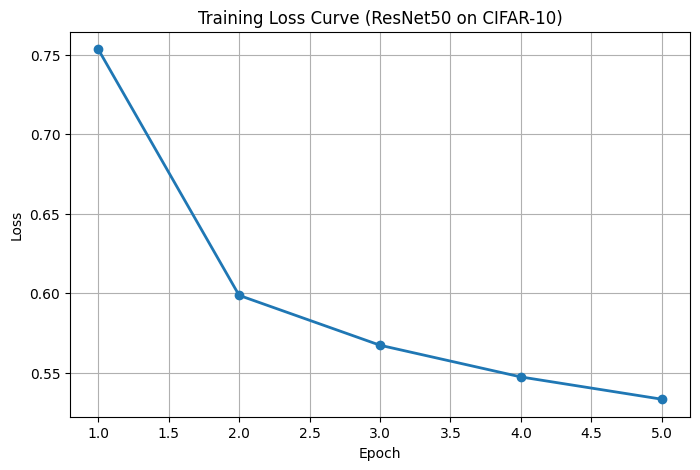

In [131]:
print(f"Clean CIFAR-10 Accuracy: {clean_acc:.2f}%")
plot_test_curve(num_epochs, clean_train_losses, title="Training Loss Curve (ResNet50 on CIFAR-10)", xlabel="Epoch", ylabel="Loss", isGrid = True)

Corruption Type          Clean Model
--------------------------------------------------
clean_test                     81.48
brightness                     77.00
contrast                       57.41
defocus_blur                   63.42
elastic_transform              62.23
fog                            67.20
frost                          59.70
gaussian_blur                  54.98
gaussian_noise                 35.50
glass_blur                     38.64
impulse_noise                  23.93
jpeg_compression               54.28
motion_blur                    52.34
pixelate                       52.66
saturate                       70.47
shot_noise                     42.35
snow                           65.68
spatter                        65.87
speckle_noise                  43.71
--------------------------------------------------
average                        56.25


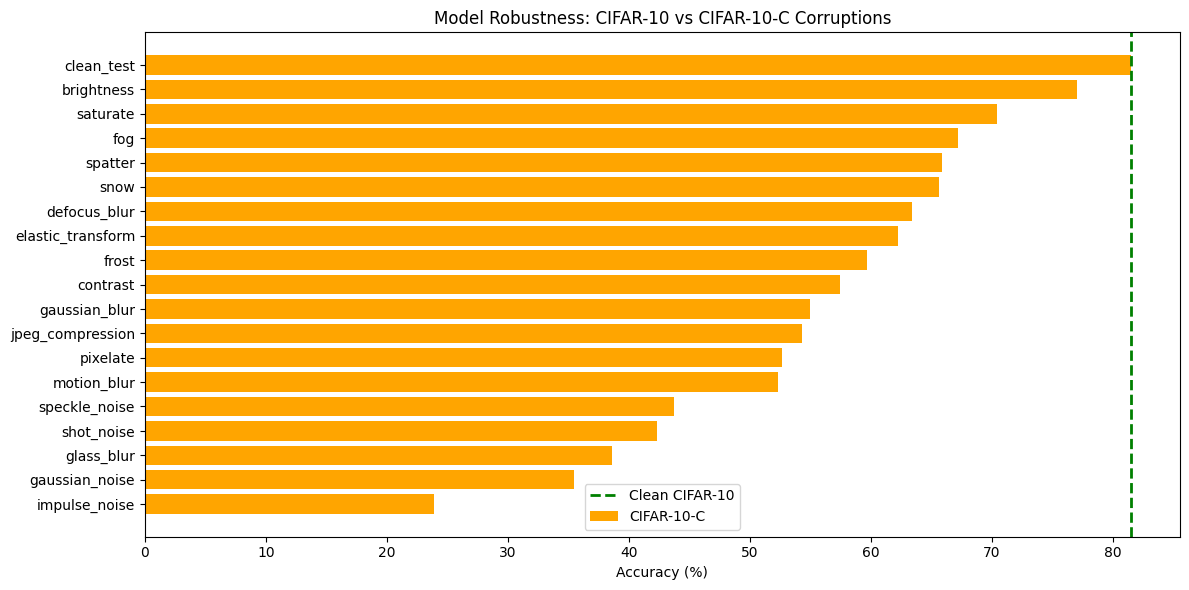

In [132]:
print(f"{'Corruption Type':<20} {'Clean Model':>15}")
print("-"*50)
for k in clean_model_acc_results.keys():
    print(f"{k:<20} {clean_model_acc_results[k]:>15.2f}")

print("-"*50)
print(f"{'average':<20} {sum(clean_model_acc_results.values())/len(clean_model_acc_results):>15.2f}")
    
plot_bar_graph(clean_model_acc_results)

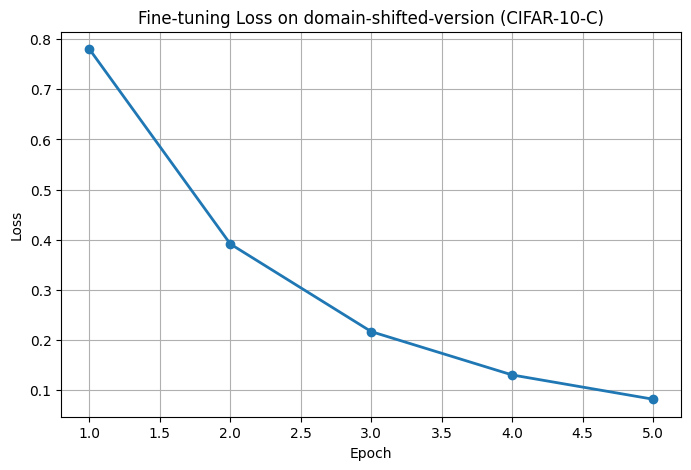

Corruption Type      Fine-tuned Model
--------------------------------------------------
clean_test                     96.98
brightness                     95.26
contrast                       89.85
defocus_blur                   94.16
elastic_transform              86.87
fog                            91.52
frost                          88.27
gaussian_blur                  92.77
gaussian_noise                 79.58
glass_blur                     78.11
impulse_noise                  81.72
jpeg_compression               82.08
motion_blur                    88.55
pixelate                       88.49
saturate                       91.62
shot_noise                     83.92
snow                           88.54
spatter                        92.12
speckle_noise                  84.77
--------------------------------------------------
average                        88.17


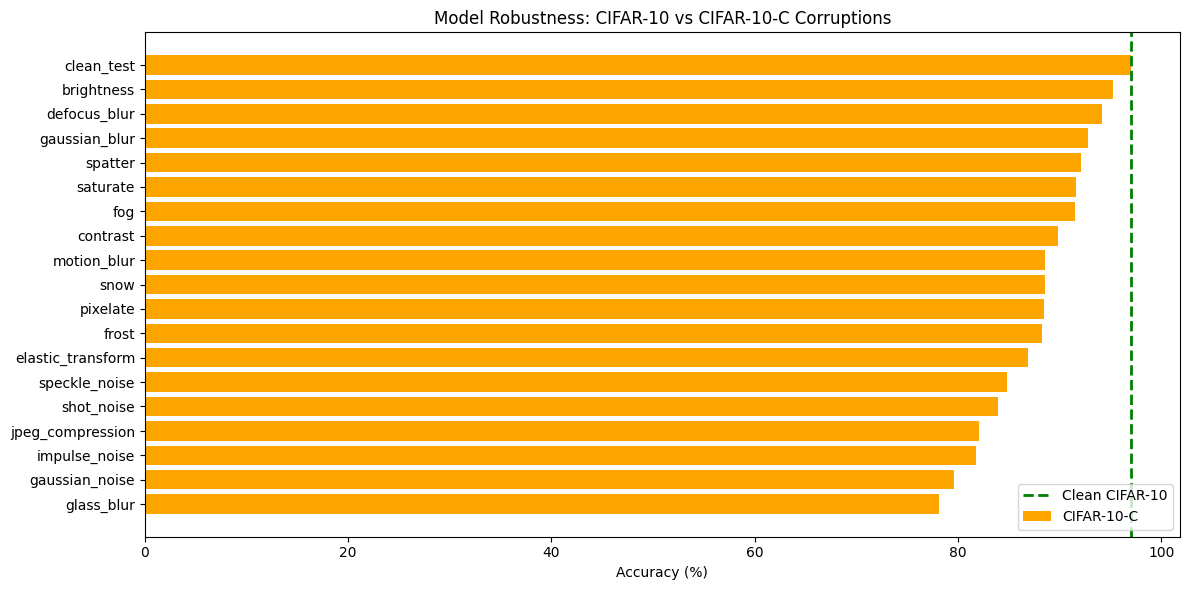

In [133]:

plot_test_curve(num_epochs, corrupt_train_losses, title=f"Fine-tuning Loss on domain-shifted-version (CIFAR-10-C)", xlabel="Epoch", ylabel="Loss")

print(f"{'Corruption Type':<20} {'Fine-tuned Model':>15}")
print("-"*50)
for k in corrupt_model_acc_results.keys():
    print(f"{k:<20} {corrupt_model_acc_results[k]:>15.2f}")


print("-"*50)
print(f"{'average':<20} {sum(corrupt_model_acc_results.values())/len(corrupt_model_acc_results):>15.2f}")
    
plot_bar_graph(corrupt_model_acc_results)

In [134]:
for (name1, p1), (name2, p2) in zip(model_clean.named_parameters(), model_corrupt.named_parameters()):
    if "layer4" in name1 or "fc" in name1:
        diff = torch.norm(p1 - p2).item()
        print(f"{name1:25s}\t: {diff:.6f}")

layer4.0.conv1.weight    	: 39.677841
layer4.0.bn1.weight      	: 0.556539
layer4.0.bn1.bias        	: 1.325417
layer4.0.conv2.weight    	: 79.532501
layer4.0.bn2.weight      	: 0.656602
layer4.0.bn2.bias        	: 1.747044
layer4.0.conv3.weight    	: 40.945156
layer4.0.bn3.weight      	: 1.968796
layer4.0.bn3.bias        	: 1.655868
layer4.0.downsample.0.weight	: 62.388168
layer4.0.downsample.1.weight	: 2.290119
layer4.0.downsample.1.bias	: 1.655868
layer4.1.conv1.weight    	: 32.920895
layer4.1.bn1.weight      	: 0.766423
layer4.1.bn1.bias        	: 0.684736
layer4.1.conv2.weight    	: 53.043816
layer4.1.bn2.weight      	: 0.746255
layer4.1.bn2.bias        	: 0.781217
layer4.1.conv3.weight    	: 32.406502
layer4.1.bn3.weight      	: 3.069430
layer4.1.bn3.bias        	: 2.601570
layer4.2.conv1.weight    	: 35.011513
layer4.2.bn1.weight      	: 0.652403
layer4.2.bn1.bias        	: 0.571545
layer4.2.conv2.weight    	: 50.279213
layer4.2.bn2.weight      	: 0.573712
layer4.2.bn2.bias     

In [ ]:
improvement = {k: corrupt_model_acc_results[k] - clean_model_acc_results[k] for k in corrupt_model_acc_results}

print(f"{'Corruption Type':<20} {'Clean Model':>15} {'Fine-tuned Model':>20} {'Improvement':>20}")
print("-"*90)
for k in corrupt_model_acc_results.keys():
    print(f"{k:<20} {clean_model_acc_results[k]:>15.2f} {corrupt_model_acc_results[k]:>20.2f} {improvement[k]:>20.2f}")

print("-"*90)
avg1 = sum(clean_model_acc_results.values())/len(clean_model_acc_results)
avg2 = sum(corrupt_model_acc_results.values())/len(corrupt_model_acc_results)
print(f"{'average':<20} {avg1:>15.2f} {avg2:>20.2f} {avg2 - avg1:>20.2f}")

Corruption Type          Clean Model     Fine-tuned Model          Improvement
------------------------------------------------------------------------------------------
clean_test                     81.48                96.98                15.50
brightness                     77.00                95.26                18.25
contrast                       57.41                89.85                32.44
defocus_blur                   63.42                94.16                30.74
elastic_transform              62.23                86.87                24.64
fog                            67.20                91.52                24.32
frost                          59.70                88.27                28.57
gaussian_blur                  54.98                92.77                37.79
gaussian_noise                 35.50                79.58                44.08
glass_blur                     38.64                78.11                39.47
impulse_noise                  23.93    

Explained variance ratio: [0.06197984 0.0348014 ]


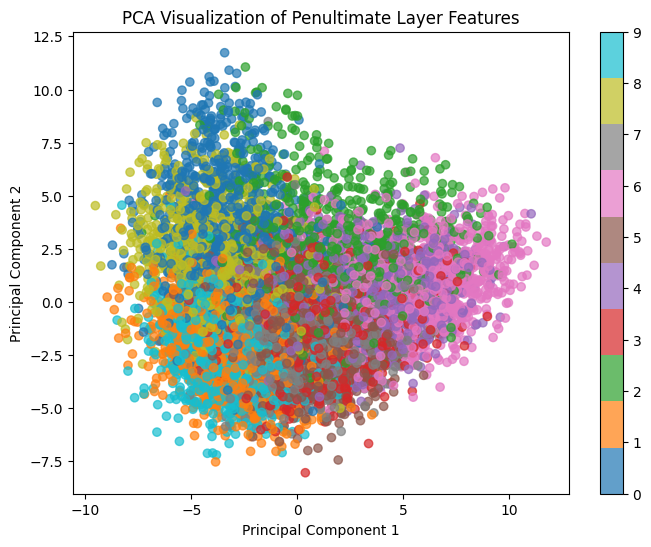

Explained variance ratio: [0.2936415  0.14505176]


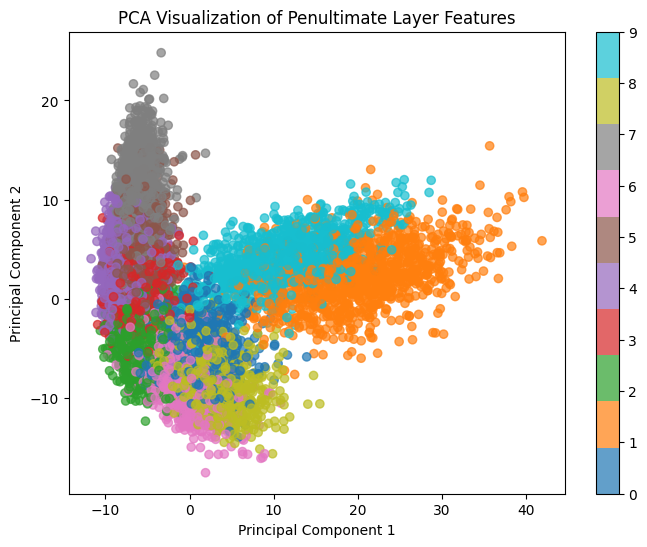

In [136]:
visualize_features_distribution(model_clean, device, 2)
visualize_features_distribution(model_corrupt, device, 2)

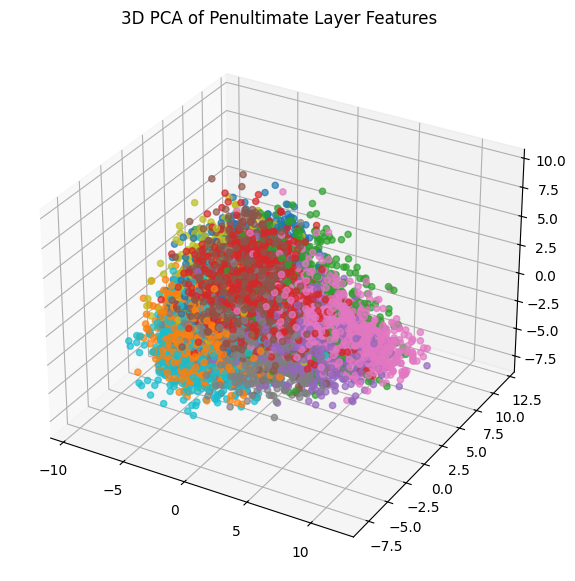

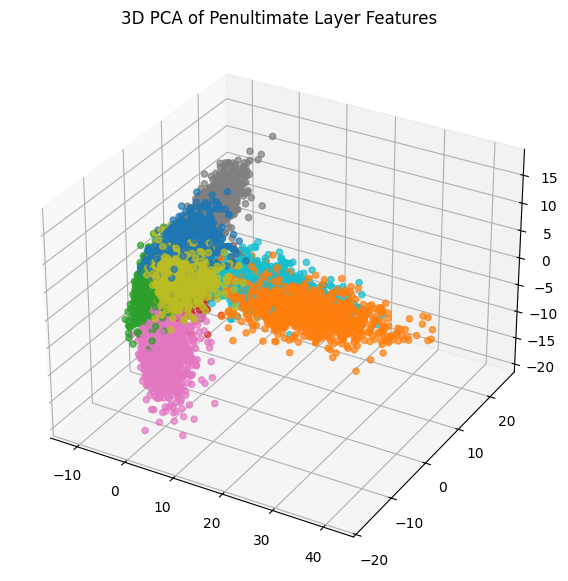

In [137]:
visualize_features_distribution(model_clean, device, 3)
visualize_features_distribution(model_corrupt, device, 3)